In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import edhec_risk_kit as erk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# define a backtest by allocation between two assets,# keyword argument, accept any argument/parameter you input
def bt_mix(r1,r2,allocator,**kwargs):
    """r1,r2 are T*N dataframes returns, T is time step, N is # of scenarios,
    allocation to the 1st portfolio return a T*1 dataframe
    return a T*N dataframe for N scenarios"""
    if not r1.shape==r2.shape:
        raise ValueError('r1, r2 need to be the same shape')
    weights=allocator(r1,r2,**kwargs)
    if not weights.shape==r1.shape:
        raise ValueError('allocator weights and r1 and r2 need to be the same')
    r_mix=weights*r1+(1-weights)*r2
    return r_mix

In [4]:
def fixedmix_allocator(r1,r2,w1,**kwargs):
    """produce a time series over T steps of allocation between PSP and GHP across N scenarios
       row is price of time step, column is scenario
       return T*N dataframe of PSP weights"""
    return pd.DataFrame(data=w1,index=r1.index,columns=r1.columns)

In [7]:
rates,zc_prices=erk.cir(10,500,b=0.03,r_0=0.03)
price_10=erk.bond_price(10,100,0.05,12,rates)
price_30=erk.bond_price(30,100,0.05,12,rates)
rets_30=erk.bond_total_return(price_30,100,0.05,12)
rets_10=erk.bond_total_return(price_10,100,0.05,12)
rets_bonds=erk.bt_mix(rets_10,rets_30,allocator=erk.fixedmix_allocator,w1=0.6)
mean_rets_bonds=rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,annualized return,annualized vol,skewness,kurtosis,cornish-fisher var 5%,historic cvar 5%,sharpe ratio,max drawdown
0,0.035812,0.003539,-0.316884,3.406567,-0.001182,-0.000656,1.598457,-0.000463


In [8]:
price_eq=erk.gbm(10,500,0.07,0.15)
rets_eq=price_eq.pct_change().dropna()
rets_zc=zc_prices.pct_change().dropna() # we can do pct change to zc bond because it does't has coupon

In [9]:
rets_7030b=erk.bt_mix(rets_eq,rets_bonds,allocator=erk.fixedmix_allocator,w1=0.7)
rets_7030b_mean=rets_7030b.mean(axis=1)
erk.summary_stats(pd.DataFrame(rets_7030b_mean))                                  

,annualized return,annualized vol,skewness,kurtosis,cornish-fisher var 5%,historic cvar 5%,sharpe ratio,max drawdown
0,0.059169,0.005576,-0.051973,2.834136,-0.002138,-0.00145,5.091661,0.0


In [10]:
# the more you put in PSP, the more your return

In [11]:
summaries=erk.summary_stats(pd.DataFrame(rets_7030b))
# run summary on 500 scenarios, then average the stat [another way]

In [12]:
summaries.head()

,annualized return,annualized vol,skewness,kurtosis,cornish-fisher var 5%,historic cvar 5%,sharpe ratio,max drawdown
0,-0.019875,0.115374,-0.148448,2.966567,0.057081,0.069784,-0.420851,-0.368453
1,0.083710,0.107900,-0.241266,2.883843,0.045984,0.060956,0.484355,-0.157988
2,0.055341,0.105904,-0.193602,2.446594,0.047108,0.057386,0.232756,-0.139837
3,0.048230,0.101163,-0.432408,3.246916,0.046804,0.066256,0.175265,-0.191120
4,0.115547,0.097623,-0.420338,3.121969,0.039804,0.058678,0.852824,-0.122371


In [13]:
summaries.mean()

annualized return        0.053732
annualized vol           0.107056
skewness                -0.005876
kurtosis                 2.948234
cornish-fisher var 5%    0.045885
historic cvar 5%         0.058033
sharpe ratio             0.217810
max drawdown            -0.210020
dtype: float64

In [14]:
## we need to look at terminal value

In [16]:
def terminal_values(rets):
    """return the final values of a dollar at the end of return period for wach scenario"""
    return (rets+1).prod()

In [17]:
pd.concat([
         erk.termianl_stats(rets_bonds,name='FI'),
         erk.termianl_stats(rets_eq,name='EQ'),
         erk.termianl_stats(rets_7030b,name='70/30')
],axis=1)

,FI,EQ,70/30
mean,1.382807,1.956746,1.773702
std,0.116901,1.017079,0.619248
p_breach,NaN,0.048000,0.020000
p_reach,NaN,NaN,NaN
e_short,NaN,0.149218,0.060399
e_surplus,NaN,NaN,NaN


In [18]:
## seaborn - visualization

C:\Users\16469\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\16469\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\16469\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

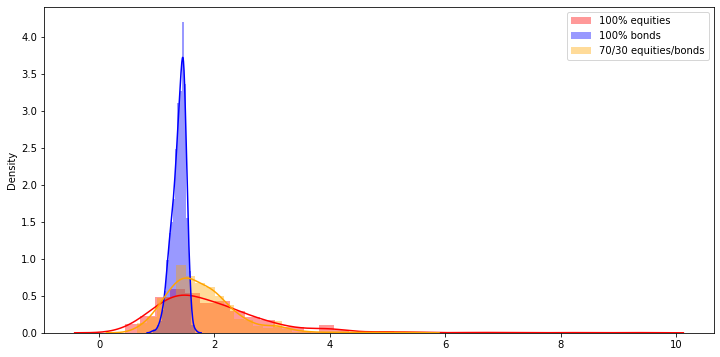

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq),color='red',label='100% equities')
sns.distplot(erk.terminal_values(rets_bonds),color='blue',label='100% bonds')
sns.distplot(erk.terminal_values(rets_7030b),color='orange',label='70/30 equities/bonds')
plt.legend();

### Glide path for allocation - target date fund style

In [23]:
# as we move to maturity, allocate more to bond

In [24]:
def glidepath_allocator(r1,r2,start_glide=1,end_glide=0):
    """simulate a target date fund style gradual move from r1 to r2"""
    n_points=r1.shape[0]
    n_col=r1.shape[1]
    path=pd.Series(data=np.linspace(start_glide,end_glide,num=n_points))
    paths=pd.concat([path]*n_col,axis=1)
    paths.index=r1.index
    paths.columns=r1.columns
    return paths

In [27]:
rets_g8020=erk.bt_mix(rets_eq,rets_bonds,allocator=erk.glidepath_allocator,start_glide=0.8,end_glide=0.2)
pd.concat([
         erk.termianl_stats(rets_bonds,name='FI'),
         erk.termianl_stats(rets_eq,name='EQ'),
         erk.termianl_stats(rets_7030b,name='70/30'),
         erk.termianl_stats(rets_g8020,name='glide 80 to 20')
],axis=1)

,FI,EQ,70/30,glide 80 to 20
mean,1.382807,1.956746,1.773702,1.672571
std,0.116901,1.017079,0.619248,0.452690
p_breach,NaN,0.048000,0.020000,0.002000
e_short,NaN,0.149218,0.060399,0.037069
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN
